In [4]:
# Import necessary libraries

from IPython.core import prefilter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import warnings

# Import MLflow for experiment tracking
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from mlflow.models.signature import infer_signature
import boto3

import matplotlib.colors
pal = ['#009473', '#00537c', '#b4b4b4', '#da3e21']
cmap = matplotlib.colors.ListedColormap(pal)
import os

os.environ['AWS_ACCESS_KEY_ID'] = 'minio'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'minio123'
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://localhost:9000'


In [5]:
# Set up MLflow tracking
# This will connect to your MLflow server (if already running) or use local tracking

# You can set the MLflow tracking URI
# If you're using a local server, use http://localhost:5000
# If you're using the server from docker-compose, use the appropriate URL

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Anemia Classification Models.")

print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"MLflow experiment: {mlflow.get_experiment_by_name('Anemia Classification Models').experiment_id}")

MLflow tracking URI: http://localhost:5000
MLflow experiment: 1


In [6]:
# Ignore specific warning categories

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
# Read the CSV file into a Pandas DataFrame

dot = pd.read_csv(r'./resource/data/children anemia.csv')

In [8]:
# Set Pandas display options to show a maximum of 100 rows and columns, and set the display width to 100 characters

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

In [9]:
# Display the first few rows of the DataFrame

dot.head()

,Age in 5-year groups,Type of place of residence,Highest educational level,Wealth index combined,Births in last five years,Age of respondent at 1st birth,Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal),Anemia level,Have mosquito bed net for sleeping (from household questionnaire),Smokes cigarettes,Current marital status,Currently residing with husband/partner,When child put to breast,Had fever in last two weeks,Hemoglobin level adjusted for altitude (g/dl - 1 decimal),Anemia level.1,"Taking iron pills, sprinkles or syrup"
0,40-44,Urban,Higher,Richest,1,22,NaN,NaN,Yes,No,Living with partner,Staying elsewhere,Immediately,No,NaN,NaN,Yes
1,35-39,Urban,Higher,Richest,1,28,NaN,NaN,Yes,No,Married,Living with her,Hours: 1,No,NaN,NaN,No
2,25-29,Urban,Higher,Richest,1,26,NaN,NaN,No,No,Married,Living with her,Immediately,No,NaN,NaN,No
3,25-29,Urban,Secondary,Richest,1,25,95.0,Moderate,Yes,No,Married,Living with her,105.0,No,114.0,Not anemic,No
4,20-24,Urban,Secondary,Richest,1,21,NaN,NaN,Yes,No,No longer living together/separated,NaN,Immediately,No,NaN,NaN,No


In [10]:
# Get the shape of the DataFrame (number of rows and columns)

dot.shape

(33924, 17)

In [11]:
# Check and count the number of missing values in each column of the DataFrame

dot.isnull().sum()

Age in 5-year groups                                                         0
Type of place of residence                                                   0
Highest educational level                                                    0
Wealth index combined                                                        0
Births in last five years                                                    0
Age of respondent at 1st birth                                               0
Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)    20788
Anemia level                                                             20788
Have mosquito bed net for sleeping (from household questionnaire)            0
Smokes cigarettes                                                            0
Current marital status                                                       0
Currently residing with husband/partner                                   1698
When child put to breast                            

In [12]:
# Get the names of the columns

dot.columns

Index(['Age in 5-year groups', 'Type of place of residence', 'Highest educational level',
       'Wealth index combined', 'Births in last five years', 'Age of respondent at 1st birth',
       'Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)', 'Anemia level',
       'Have mosquito bed net for sleeping (from household questionnaire)', 'Smokes cigarettes',
       'Current marital status', 'Currently residing with husband/partner',
       'When child put to breast', 'Had fever in last two weeks',
       'Hemoglobin level adjusted for altitude (g/dl - 1 decimal)', 'Anemia level.1',
       'Taking iron pills, sprinkles or syrup'],
      dtype='object')

In [13]:
# Rename columns for better clarity and ease of analysis

dot.rename(columns={'Age in 5-year groups': 'age',
                   'Type of place of residence': 'residence',
                   'Highest educational level': 'highest_educational',
                   'Wealth index combined': 'wealth_index',
                   'Births in last five years': 'births_5_years',
                   'Age of respondent at 1st birth': 'respondent_1st_birth',
                   'Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)': 'hemoglobin_altitude_smoking',
                   'Anemia level': 'anemia_level_target',
                   'Have mosquito bed net for sleeping (from household questionnaire)': 'mosquito_bed_sleeping',
                   'Smokes cigarettes': 'smoking',
                   'Current marital status': 'status',
                   'Currently residing with husband/partner': 'residing_husband_partner',
                   'When child put to breast': 'child_put_breast',
                   'Had fever in last two weeks': 'fever_two_weeks',
                   'Hemoglobin level adjusted for altitude (g/dl - 1 decimal)': 'hemoglobin_altitude',
                   'Anemia level.1': 'anemia_level_1',
                   'Taking iron pills, sprinkles or syrup': 'iron_pills'}, inplace=True)


In [14]:
# Function to replace NaN values with the mean of the column
def reloc_nan(x):
    """
    Replace NaN values in a pandas Series with the mean of the column.

    """
    mean_value = x.mean()  # Calculate the mean value of the column
    return x.fillna(mean_value)  # Replace NaN values with the mean


In [15]:
# Replace NaN values in the 'hemoglobin_altitude_smoking' column with the mean of the column

dot['hemoglobin_altitude_smoking'] = reloc_nan(dot['hemoglobin_altitude_smoking'])

In [16]:
# Define a function to replace NaN values in the 'residing_husband_partner' column with a specific word

def replace_nan_residing(x):
    """
    Replace NaN values in a pandas Series with a specific word.

    """
    word = 'Staying elsewhere'  # Specify the word to replace NaN values
    return x.fillna(word)  # Replace NaN values with the specified word

# Apply the function to replace NaN values in the 'residing_husband_partner' column
dot['residing_husband_partner'] = replace_nan_residing(dot['residing_husband_partner'])


In [17]:
# Convert categorical values in 'child_put_breast' column to numerical representation

def func_child_put_breast(dot):

    values = dot['child_put_breast'].values
    for idx, val in enumerate(values):
        values[idx] = 0 if val == 'Immediately' else (0.5 if val == 'Hours: 1' else (1 if val == 'Days: 1' else val))
    dot['child_put_breast'] = values
    return dot

# Apply function to convert categorical values in 'child_put_breast' column
dot = func_child_put_breast(dot)


In [18]:
# Convert the 'child_put_breast' column to the float64 data type

dot['child_put_breast'] = dot['child_put_breast'].astype('float64')


In [19]:
# Replace NaN values in the 'child_put_breast' column with the mean of the column

dot['child_put_breast'] = reloc_nan(dot['child_put_breast'])


In [20]:
# Fill NaN values in the 'fever_two_weeks' column with the string "Dont know"

dot['fever_two_weeks'] = dot['fever_two_weeks'].fillna("Dont know")


In [21]:
# Replace NaN values in 'hemoglobin_altitude' column with the mean and round to 1 decimal place

dot['hemoglobin_altitude'] = reloc_nan(dot['hemoglobin_altitude']).apply(lambda x: round(x, 1))


In [22]:
# Fill NaN values in specified columns with the string "Dont know"

dot['anemia_level_1'] = dot['anemia_level_1'].fillna("Dont know")
dot['iron_pills'] = dot['iron_pills'].fillna("Dont know")
dot['anemia_level_target'] = dot['anemia_level_target'].fillna("Dont know")


In [23]:
# Define a function to replace specific values in the DataFrame with standardized values

def func_replace(dot):

    def val_replace(value):
        if value == "Don't know":
            return 'Dont know'
        else:
            return value

    # Apply the value replacement function to all elements in the DataFrame
    dot = dot.applymap(val_replace)
    return dot

# Apply the function to replace specific values in the DataFrame
dot = func_replace(dot)


In [24]:
# Generate and transpose descriptive statistics summary for the DataFrame

dot.describe().T


,count,mean,std,min,25%,50%,75%,max
births_5_years,33924.0,1.823783,0.705460,1.0,1.000000,2.000000,2.000000,6.0
respondent_1st_birth,33924.0,19.570776,4.313172,12.0,16.000000,19.000000,22.000000,48.0
hemoglobin_altitude_smoking,33924.0,114.367235,9.903431,20.0,114.367235,114.367235,114.367235,218.0
child_put_breast,33924.0,40.690429,48.417658,0.0,0.000000,40.690429,40.690429,223.0
hemoglobin_altitude,33924.0,101.291051,8.529540,29.0,101.300000,101.300000,101.300000,170.0


In [25]:
# Define a function to calculate the mean of age groups represented as strings

def func_mean_column_age(x):
  
    if isinstance(x, str):
        start, end = map(int, x.split('-'))
        return (start + end) / 2
    else:
        return x

# Apply the function to calculate the mean of age groups in the 'age' column
dot['age'] = dot['age'].apply(lambda x: func_mean_column_age(x) if isinstance(x, str) else x)


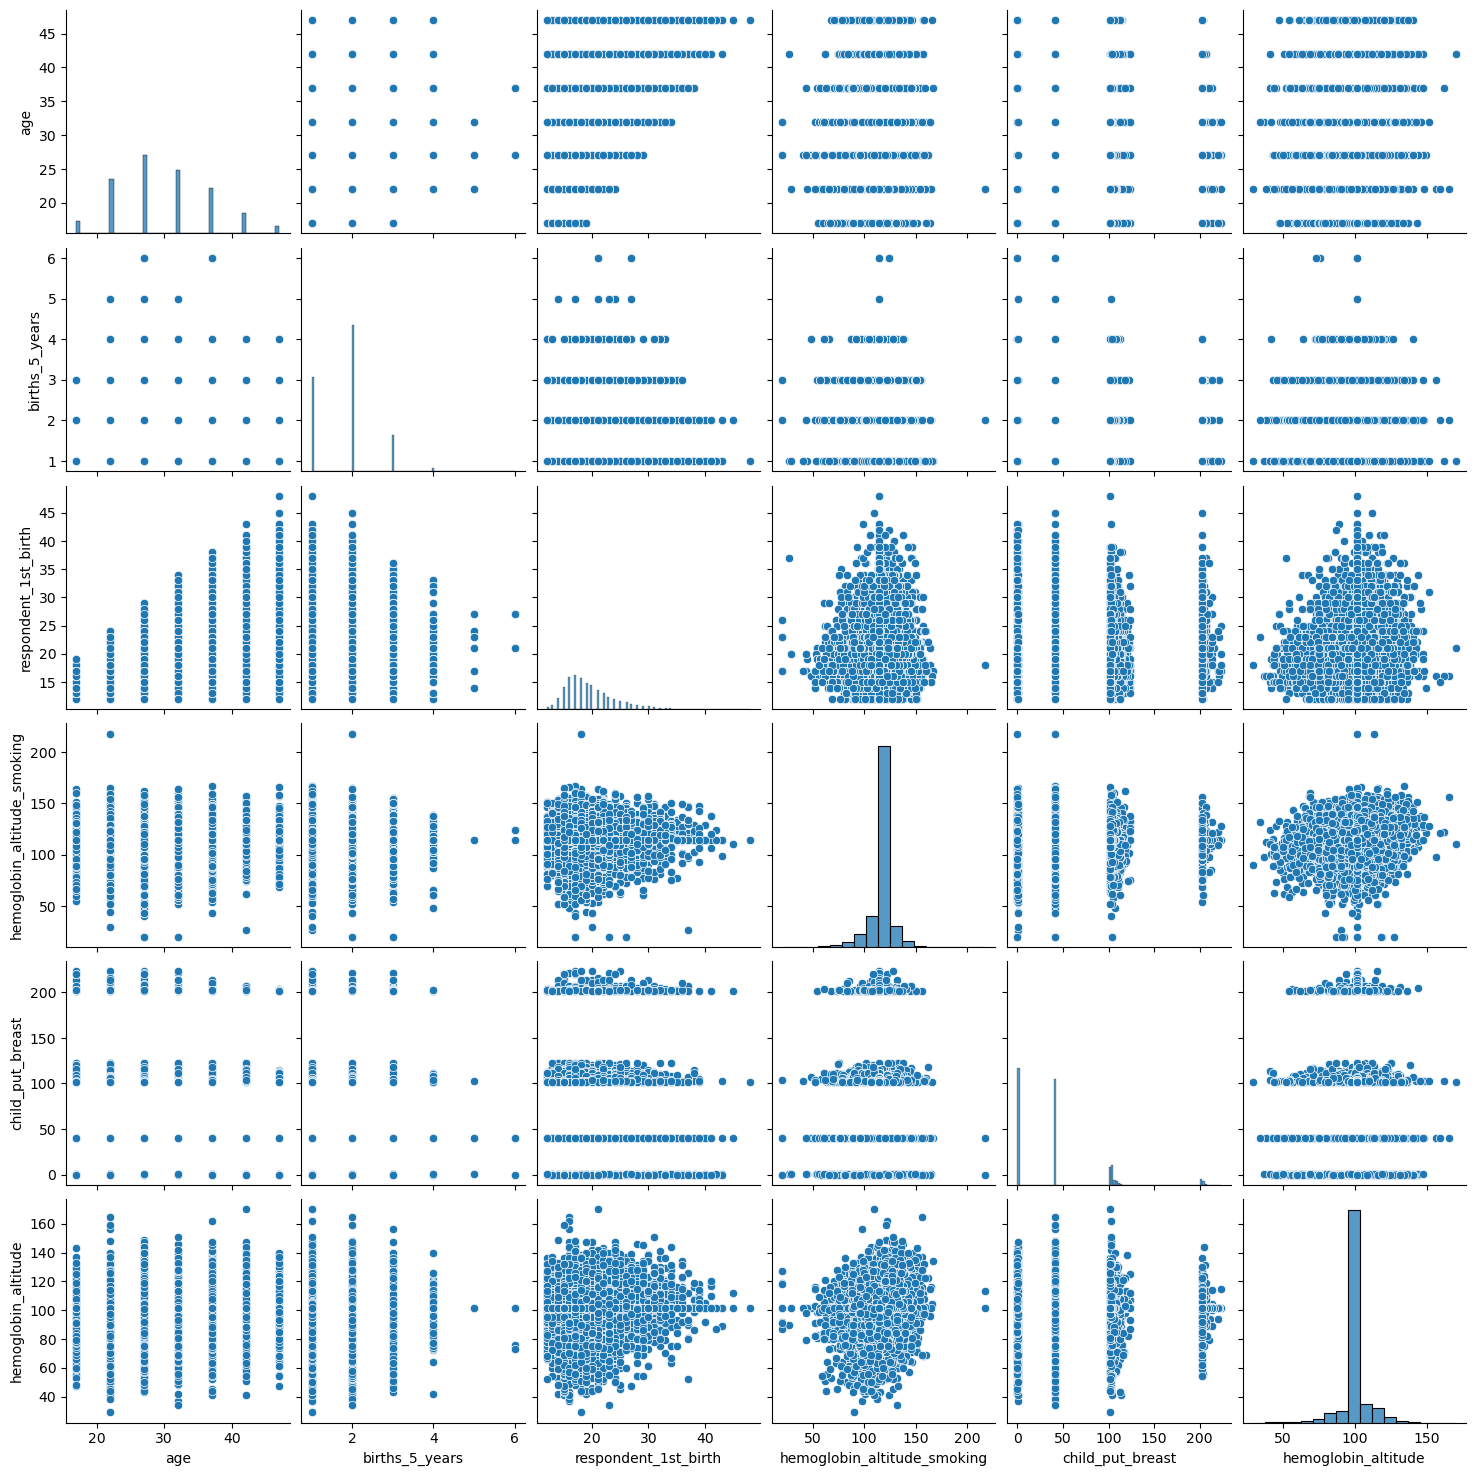

In [26]:
# Generate a pair plot for visualizing relationships between numerical variables

sns.pairplot(dot)


In [27]:

# Map 'Yes' to 1 and 'No' to 0 in specified columns

col = ['mosquito_bed_sleeping', 'smoking', 'fever_two_weeks', 'iron_pills']

for column in col:
    dot[column] = dot[column].map({'Yes': 1, 'No': 0})


In [28]:
# Display the unique values in the 'status' column

dot['status'].unique()


array(['Living with partner', 'Married',
       'No longer living together/separated', 'Never in union', 'Widowed',
       'Divorced'], dtype=object)

In [29]:
# Replace 'No longer living together/separated' with 'Separated' in the 'status' column

dot['status'] = dot['status'].replace('No longer living together/separated', 'Separated')


In [30]:

# Create dummy variables for specified categorical columns and concatenate them to the DataFrame

col = ['residence', 'highest_educational', 'wealth_index']

for column in col:
    # Generate dummy variables and drop the first category to avoid multicollinearity
    status = pd.get_dummies(dot[column], prefix=column, drop_first=False)
    
    # Concatenate dummy variables to the original DataFrame
    dot = pd.concat([dot, status], axis=1)



In [31]:
# Drop specified columns 'residence', 'highest_educational', 'wealth_index' from the DataFrame

dot = dot.drop(columns=['residence', 'highest_educational', 'wealth_index'], axis=1)


In [32]:
# Display the first few rows of the modified DataFrame

dot.head()


,age,births_5_years,respondent_1st_birth,hemoglobin_altitude_smoking,anemia_level_target,mosquito_bed_sleeping,smoking,status,residing_husband_partner,child_put_breast,fever_two_weeks,hemoglobin_altitude,anemia_level_1,iron_pills,residence_Rural,residence_Urban,highest_educational_Higher,highest_educational_No education,highest_educational_Primary,highest_educational_Secondary,wealth_index_Middle,wealth_index_Poorer,wealth_index_Poorest,wealth_index_Richer,wealth_index_Richest
0,42.0,1,22,114.367235,Dont know,1,0,Living with partner,Staying elsewhere,0.0,0.0,101.3,Dont know,1.0,False,True,True,False,False,False,False,False,False,False,True
1,37.0,1,28,114.367235,Dont know,1,0,Married,Living with her,0.5,0.0,101.3,Dont know,0.0,False,True,True,False,False,False,False,False,False,False,True
2,27.0,1,26,114.367235,Dont know,0,0,Married,Living with her,0.0,0.0,101.3,Dont know,0.0,False,True,True,False,False,False,False,False,False,False,True
3,27.0,1,25,95.000000,Moderate,1,0,Married,Living with her,105.0,0.0,114.0,Not anemic,0.0,False,True,False,False,False,True,False,False,False,False,True
4,22.0,1,21,114.367235,Dont know,1,0,Separated,Staying elsewhere,0.0,0.0,101.3,Dont know,0.0,False,True,False,False,False,True,False,False,False,False,True


In [33]:
# Drop rows with any missing values from the DataFrame

dot = dot.dropna()


In [34]:
# Copy DataSet
dot_df_copy = dot.copy()

In [35]:
# Separate features (X) and target variable (y) from the DataFrame

X = dot.drop(columns=['anemia_level_target'], axis=1)  # Features
y = dot['anemia_level_target']  # Target variable


In [36]:
# Identify columns with object (categorical) data in the features (X)

obj = [col for col in X.columns if dot[col].dtype == 'object']


In [37]:
# List of column names in X with 'object' data type (likely categorical variables)

print(obj)


['status', 'residing_husband_partner', 'anemia_level_1']


In [38]:
# Display the unique values in the target variable (y)

y.unique()


array(['Dont know', 'Moderate', 'Mild', 'Not anemic', 'Severe'],
      dtype=object)

In [39]:

# Apply Label Encoding to categorical columns in the features (X)

for i in obj:
    lr = LabelEncoder()  # Initialize a LabelEncoder for the current column
    X[i] = lr.fit_transform(X[i])  # Transform the categorical values to numerical labels




In [40]:
# Map categories in the target variable (y) to numerical labels

y = y.map({'Dont know': 0, 'Moderate': 1, 'Mild': 2, 'Not anemic': 3, 'Severe': 4})


In [41]:

# Split the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)


In [42]:

# Standardize the features using StandardScaler

std = StandardScaler()
X = std.fit_transform(X)


In [43]:
# Enable MLflow autologging for supported libraries
mlflow.autolog()

2025/04/25 16:28:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.


2025/04/25 16:29:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


Logistic Regression run logged with ID: 262ade50ed8d4a59b81bc8f8e953ff80


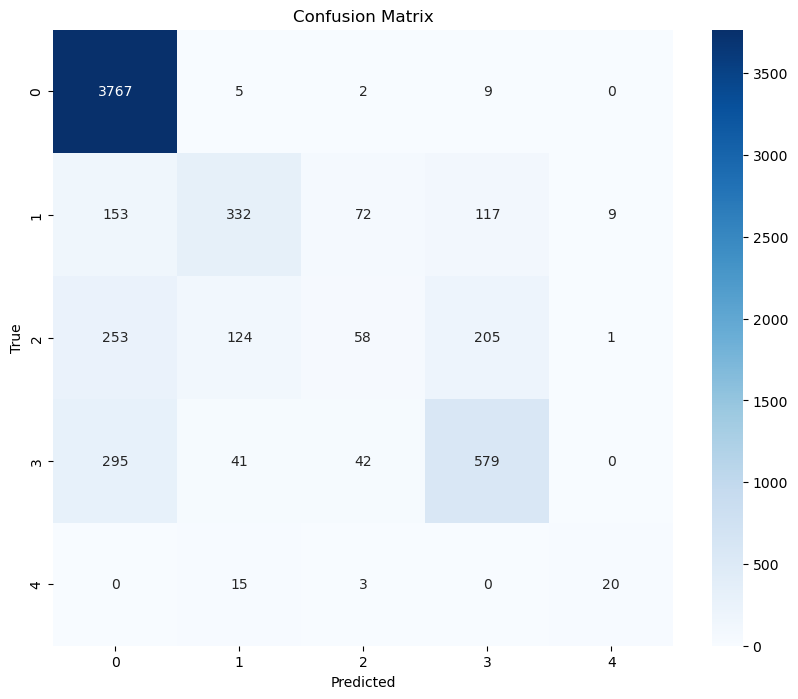

In [44]:
# Create a Logistic Regression model, fit it on the training data, and predict on the test data

# Define model parameters
max_iter = 100
solver = 'lbfgs'
random_state = 42

# End any existing MLflow run before starting a new one
if mlflow.active_run() is not None:
    mlflow.end_run()

# Start MLflow run for Logistic Regression
with mlflow.start_run(run_name="Logistic Regression"):
    # Create and train the model
    lrg = LogisticRegression(max_iter=max_iter, solver=solver, random_state=random_state)
    lrg.fit(X_train, y_train)
    y_pred = lrg.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    msre = np.sqrt(mse)
    
    # Generate classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = report['accuracy']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    
    # Log metrics
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("rmse", msre)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    
    # Log detailed class metrics
    for class_label in report.keys():
        if class_label not in ['accuracy', 'macro avg', 'weighted avg']:
            mlflow.log_metric(f"precision_class_{class_label}", report[class_label]['precision'])
            mlflow.log_metric(f"recall_class_{class_label}", report[class_label]['recall'])
            mlflow.log_metric(f"f1_class_{class_label}", report[class_label]['f1-score'])
            mlflow.log_metric(f"support_class_{class_label}", report[class_label]['support'])
    
    # Save confusion matrix as artifact
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix_lr.png')
    mlflow.log_artifact('confusion_matrix_lr.png', 'confusion_matrix')
    
    # Log model
    mlflow.sklearn.log_model(lrg, "model")
    
    # Get the run ID for reference
    run_id = mlflow.active_run().info.run_id
    print(f"Logistic Regression run logged with ID: {run_id}")

In [45]:
# Create a Decision Tree Classifier model with MLflow tracking

# Start MLflow run for Decision Tree
with mlflow.start_run(run_name="Decision Tree Classifier"):
    # Define model parameters
    random_state = 42

    # Create and train the model
    dtc = DecisionTreeClassifier(random_state=random_state)
    dtc.fit(X_train, y_train)
    y_pred_dtc = dtc.predict(X_test)
    
    # Generate classification report
    report = classification_report(y_test, y_pred_dtc, output_dict=True)
    accuracy = report['accuracy']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    
    # Log parameters
    mlflow.log_param("random_state", random_state)
    
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    
    # Log model
    mlflow.sklearn.log_model(dtc, "model")
    
    # Get the run ID for reference
    run_id = mlflow.active_run().info.run_id
    print(f"Decision Tree Classifier run logged with ID: {run_id}")

Decision Tree Classifier run logged with ID: cc5a52cd14324db0af4e96c00134d659


In [46]:

# Print the classification report for the Decision Tree Classifier model

print('Decision Tree Classifier Classification Report:\n', classification_report(y_test, y_pred_dtc))


Decision Tree Classifier Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3783
           1       0.91      0.93      0.92       683
           2       0.85      0.82      0.84       641
           3       0.94      0.95      0.95       957
           4       0.90      0.95      0.92        38

    accuracy                           0.97      6102
   macro avg       0.92      0.93      0.93      6102
weighted avg       0.96      0.97      0.97      6102



In [47]:
# Create Random Forest, Extra Trees, and Gradient Boosting classifiers with MLflow tracking

# Random Forest with MLflow
with mlflow.start_run(run_name="Random Forest Classifier"):
    # Define model parameters
    random_state = 42
    n_estimators = 100

    # Create and train the model
    rd = RandomForestClassifier(random_state=random_state, n_estimators=n_estimators)
    rd.fit(X_train, y_train)
    y_pred_rd = rd.predict(X_test)
    
    # Generate classification report
    report = classification_report(y_test, y_pred_rd, output_dict=True)
    accuracy = report['accuracy']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    
    # Log parameters
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("n_estimators", n_estimators)
    
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    
    # Log model
    mlflow.sklearn.log_model(rd, "model")
    
    # Get the run ID for reference
    run_id = mlflow.active_run().info.run_id
    print(f"Random Forest run logged with ID: {run_id}")

# Extra Trees with MLflow
with mlflow.start_run(run_name="Extra Trees Classifier"):
    # Define model parameters
    random_state = 42
    n_estimators = 100

    # Create and train the model
    ex = ExtraTreesClassifier(random_state=random_state, n_estimators=n_estimators)
    ex.fit(X_train, y_train)
    y_pred_ex = ex.predict(X_test)
    
    # Generate classification report
    report = classification_report(y_test, y_pred_ex, output_dict=True)
    accuracy = report['accuracy']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    
    # Log parameters
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("n_estimators", n_estimators)
    
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    
    # Log model
    mlflow.sklearn.log_model(ex, "model")
    
    # Get the run ID for reference
    run_id = mlflow.active_run().info.run_id
    print(f"Extra Trees run logged with ID: {run_id}")

# Gradient Boosting with MLflow
with mlflow.start_run(run_name="Gradient Boosting Classifier"):
    # Define model parameters
    random_state = 42
    n_estimators = 100
    learning_rate = 0.1

    # Create and train the model
    gb = GradientBoostingClassifier(random_state=random_state, n_estimators=n_estimators, learning_rate=learning_rate)
    gb.fit(X_train, y_train)
    y_pred_gb = gb.predict(X_test)
    
    # Generate classification report
    report = classification_report(y_test, y_pred_gb, output_dict=True)
    accuracy = report['accuracy']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    
    # Log parameters
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("learning_rate", learning_rate)
    
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    
    # Log model
    mlflow.sklearn.log_model(gb, "model")
    
    # Get the run ID for reference
    run_id = mlflow.active_run().info.run_id
    print(f"Gradient Boosting run logged with ID: {run_id}")

# Print classification reports for each classifier
print('Random Forest Classifier:')
print(classification_report(y_test, y_pred_rd))
print('Extra Trees Classifier:')
print(classification_report(y_test, y_pred_ex))
print('Gradient Boosting Classifier:')
print(classification_report(y_test, y_pred_gb))

Random Forest run logged with ID: d6a5b4e2d9ae402b880ed97674ac8c37
Extra Trees run logged with ID: eed7a5dac8514f57a6b7ee2e2e77020c
Extra Trees run logged with ID: eed7a5dac8514f57a6b7ee2e2e77020c
Gradient Boosting run logged with ID: 4f408640197441f09e884b95940f2f88
Random Forest Classifier:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3783
           1       0.85      0.99      0.91       683
           2       0.86      0.84      0.85       641
           3       1.00      0.94      0.97       957
           4       1.00      0.13      0.23        38

    accuracy                           0.96      6102
   macro avg       0.94      0.78      0.79      6102
weighted avg       0.97      0.96      0.96      6102

Extra Trees Classifier:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      3783
           1       0.81      0.84      0.83       683
           2       0.70      0

In [48]:
# Create an XGBoost Classifier instead of Regressor (since this is a classification task)
from xgboost import XGBClassifier

# Create the XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Define the hyperparameter grid for grid search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.01, 0.1]
}

# Flag to track if we're using grid search results or fallback model
using_grid_search = False

# Perform grid search with cross-validation
# Using try-except to handle potential compatibility issues
try:
    gridcv = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5)
    gridcv.fit(X_train, y_train)
    
    # Print the best hyperparameters from the grid search
    print('The best parameters are:', gridcv.best_params_)
    
    # Get the best estimator from GridSearchCV
    xgb_model = gridcv.best_estimator_
    using_grid_search = True
    
    # Make predictions on the test data using the best model from grid search
    y_pred_xgb = xgb_model.predict(X_test)
    
    # Print the classification report for XGBoost Classifier
    print('XGBoost Classifier Classification Report:')
    print(classification_report(y_test, y_pred_xgb))
except Exception as e:
    print(f"Error with GridSearchCV: {e}")
    # Fallback to a simple XGBoost model with fixed parameters
    print("Falling back to simple XGBoost model")
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',
                           n_estimators=100, max_depth=4, learning_rate=0.1)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    print('XGBoost Classifier Classification Report:')
    print(classification_report(y_test, y_pred_xgb))

# Create a continuous prediction for visualization (as if it were regression)
# This will be used later for visualization purposes
y_pred_xgb_regres = xgb_model.predict_proba(X_test)
# Convert probabilities to a single value (weighted average)
y_pred_xgb_regres_round = np.zeros(len(y_pred_xgb))
for i in range(len(y_pred_xgb)):
    # Create a weighted value based on class probabilities
    # Classes are 0, 1, 2, 3, 4 (from Dont know to Severe)
    weighted_sum = 0
    for class_idx in range(len(y_pred_xgb_regres[i])):
        weighted_sum += class_idx * y_pred_xgb_regres[i, class_idx]
    # Round to the nearest integer class
    y_pred_xgb_regres_round[i] = round(weighted_sum)

# Track with MLflow
with mlflow.start_run(run_name="XGBoost Classifier"):
    # Log parameters - either from grid search or defaults
    if using_grid_search:
        for param, value in gridcv.best_params_.items():
            mlflow.log_param(param, value)
    else:
        mlflow.log_param("n_estimators", 100)
        mlflow.log_param("max_depth", 4)
        mlflow.log_param("learning_rate", 0.1)
    
    # Generate classification report
    report = classification_report(y_test, y_pred_xgb, output_dict=True)
    
    # Log metrics
    mlflow.log_metric("accuracy", report['accuracy'])
    mlflow.log_metric("precision_weighted", report['weighted avg']['precision'])
    mlflow.log_metric("recall_weighted", report['weighted avg']['recall'])
    mlflow.log_metric("f1_weighted", report['weighted avg']['f1-score'])
    
    # Log detailed class metrics
    for class_label in report.keys():
        if class_label not in ['accuracy', 'macro avg', 'weighted avg']:
            mlflow.log_metric(f"precision_class_{class_label}", report[class_label]['precision'])
            mlflow.log_metric(f"recall_class_{class_label}", report[class_label]['recall'])
            mlflow.log_metric(f"f1_class_{class_label}", report[class_label]['f1-score'])
    
    # Log model
    mlflow.xgboost.log_model(xgb_model, "model")
    
    # Get the run ID for reference
    run_id = mlflow.active_run().info.run_id
    print(f"XGBoost Classifier run logged with ID: {run_id}")

2025/04/25 16:30:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '34aed5bdca1841288ab7a0057b356a86', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2025/04/25 16:31:12 INFO mlflow.sklearn.utils: Logging the 5 best runs, 3 runs will be omitted.


The best parameters are: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
XGBoost Classifier Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3783
           1       0.88      0.99      0.93       683
           2       0.89      0.86      0.88       641
           3       1.00      0.93      0.96       957
           4       0.86      1.00      0.93        38

    accuracy                           0.97      6102
   macro avg       0.93      0.96      0.94      6102
weighted avg       0.97      0.97      0.97      6102

XGBoost Classifier run logged with ID: 8483b16491bc4c10b01cd740519639fb
XGBoost Classifier run logged with ID: 8483b16491bc4c10b01cd740519639fb


In [49]:
# Check if y_pred_xgb_regres_round is defined, if not, create it from y_pred_xgb
try:
    # Test if the variable exists
    y_pred_xgb_regres_round
except NameError:
    print("Creating y_pred_xgb_regres_round as it was not defined earlier")
    # Create it based on the predictions we have
    try:
        # Try to use predict_proba if it exists (preferred)
        y_pred_xgb_regres = xgb_model.predict_proba(X_test)
        y_pred_xgb_regres_round = np.zeros(len(y_pred_xgb))
        for i in range(len(y_pred_xgb)):
            # Create a weighted value based on class probabilities
            weighted_sum = 0
            for class_idx in range(len(y_pred_xgb_regres[i])):
                weighted_sum += class_idx * y_pred_xgb_regres[i, class_idx]
            # Round to the nearest integer class
            y_pred_xgb_regres_round[i] = round(weighted_sum)
    except Exception as e:
        print(f"Error creating weighted predictions: {e}")
        print("Creating simple rounded predictions instead")
        # Fall back to just using y_pred_xgb directly
        y_pred_xgb_regres_round = np.array(y_pred_xgb).astype(float)

# Now proceed with the original code
# Align DataFrame indices with the length of y_pred_xgb_regres_round
dot_df_copy = dot_df_copy.reindex(range(len(y_pred_xgb_regres_round)))

# Take the first len(X_test) elements from y_pred_xgb_regres_round
y_pred_xgb_regres_round_adjusted = y_pred_xgb_regres_round[:len(X_test)]

# Add a new column 'Result' to dot_df_copy and assign adjusted predictions
dot_df_copy['Result'] = y_pred_xgb_regres_round_adjusted



In [50]:
# Map Predicted values in 'Result' column to corresponding severity levels

dot_df_copy['Result'] = dot_df_copy['Result'].map({0: 'Dont know', 1: 'Moderate', 2: 'Mild', 3: 'Not anemic', 4: 'Severe'})

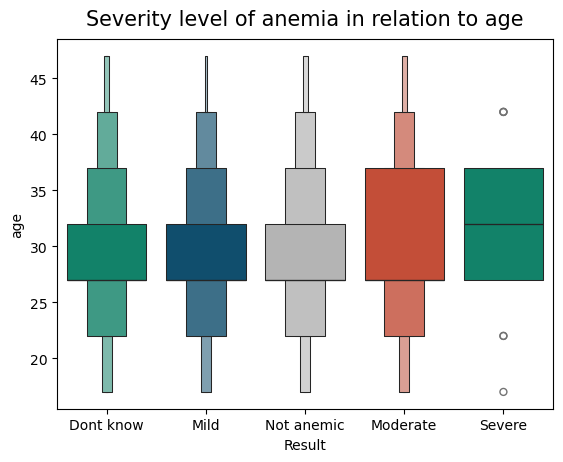

In [51]:
# Create a boxenplot to visualize the relationship between the severity levels of anemia and age

plt.figure()
pl = sns.boxenplot(x=dot_df_copy['Result'], y=dot_df_copy['age'], palette=pal)
pl.set_title("Severity level of anemia in relation to age", pad=10, size=15)
plt.show()


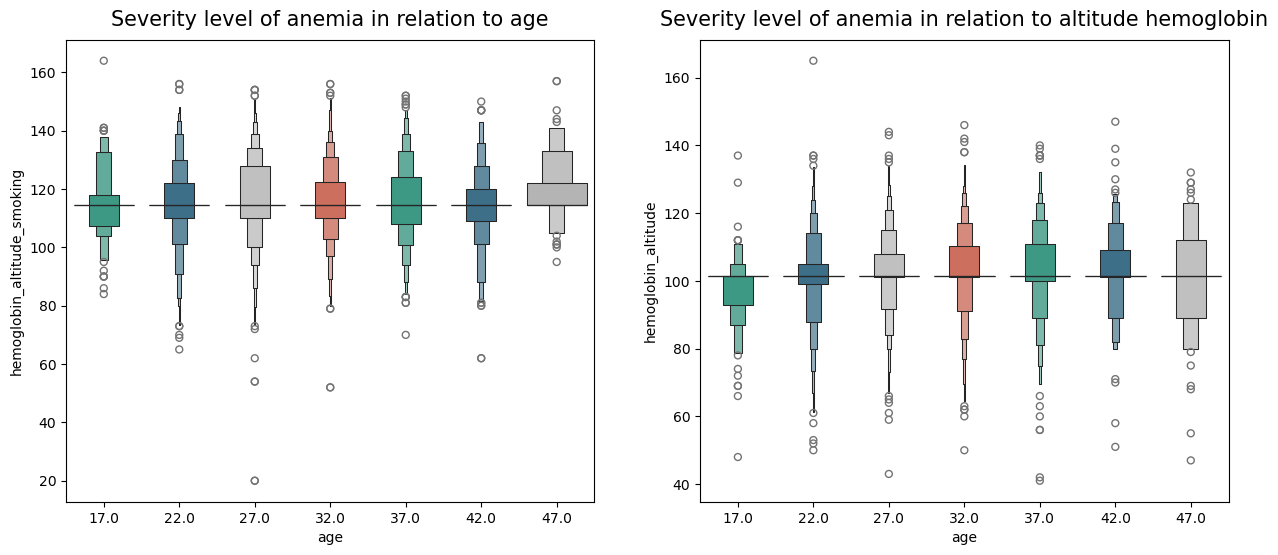

In [52]:

# Create a grid with two subplots on the horizontal axis
# The visualization of data for a smoker and a non-smoker based on age

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Boxenplot for the first column
sns.boxenplot(x=dot_df_copy['age'], y=dot_df_copy['hemoglobin_altitude_smoking'], palette=pal, ax=axs[0])
axs[0].set_title("Severity level of anemia in relation to age", pad=10, size=15)

# Boxenplot for the second column
sns.boxenplot(x=dot_df_copy['age'], y=dot_df_copy['hemoglobin_altitude'], palette=pal, ax=axs[1])
axs[1].set_title("Severity level of anemia in relation to altitude hemoglobin", pad=10, size=15)

# Display the subplots
plt.show()


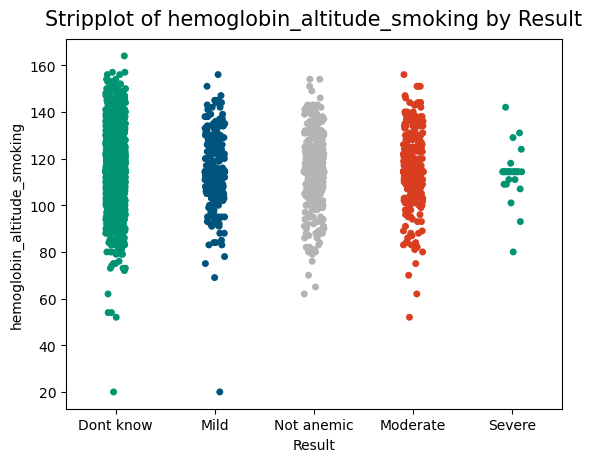

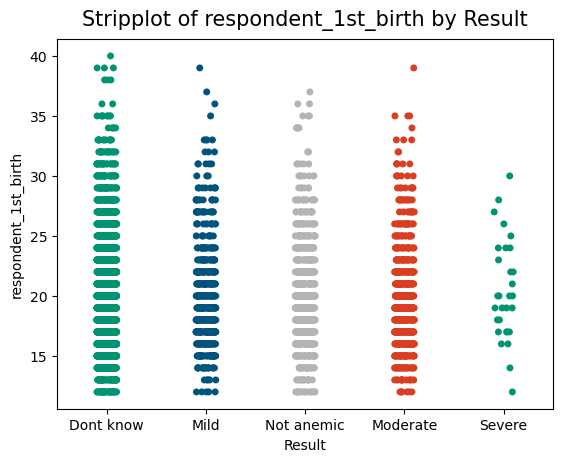

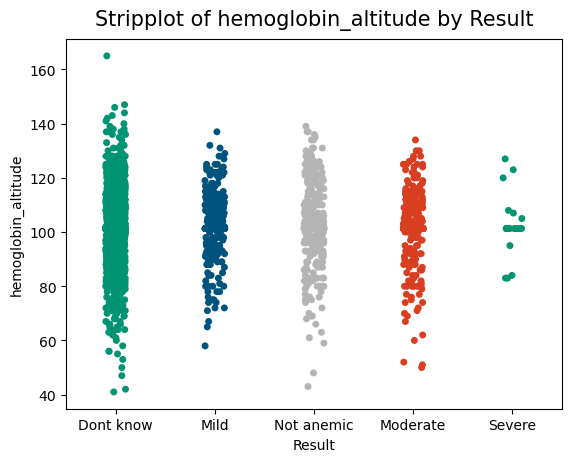

In [53]:
# Create strip plots to visualize the relationship between different columns and the severity levels of anemia

columns = ['hemoglobin_altitude_smoking', 'respondent_1st_birth', 'hemoglobin_altitude']

for i in columns:
    plt.figure()
    sns.stripplot(x=dot_df_copy["Result"], y=dot_df_copy[i], palette=pal, jitter=True)
    plt.title(f'Stripplot of {i} by Result', pad=10, size=15)
    plt.show()


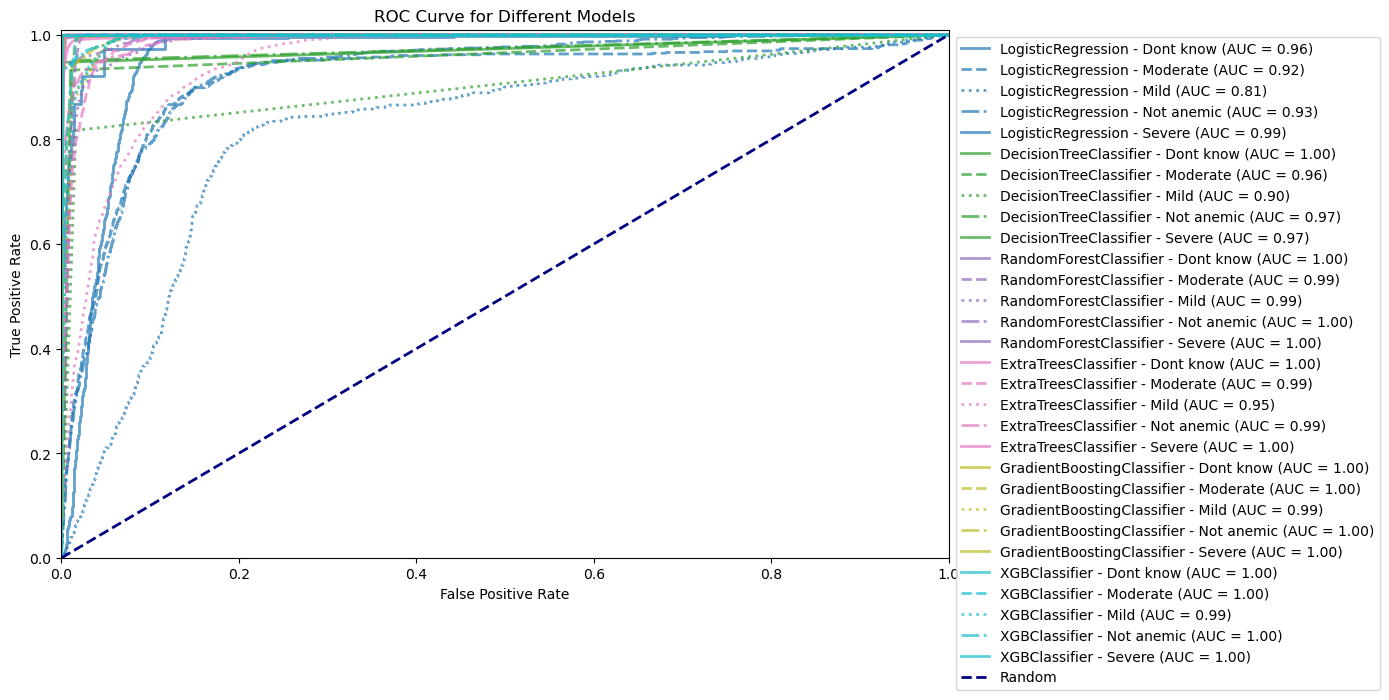

In [54]:
from sklearn.metrics import roc_auc_score  
# Add this import to fix the error
# List of models and their corresponding predicted probabilities
# We need probabilities for ROC curve, not just the predictions
models_proba = []

# Get probabilities for each model (for those that support predict_proba)
try:
    # LogisticRegression with probability
    y_pred_lr_proba = lrg.predict_proba(X_test)
    models_proba.append(('LogisticRegression', y_pred_lr_proba))
except Exception as e:
    print(f"Could not get probabilities for LogisticRegression: {e}")

try:
    # DecisionTree with probability
    y_pred_dtc_proba = dtc.predict_proba(X_test)
    models_proba.append(('DecisionTreeClassifier', y_pred_dtc_proba))
except Exception as e:
    print(f"Could not get probabilities for DecisionTreeClassifier: {e}")

try:
    # RandomForest with probability
    y_pred_rd_proba = rd.predict_proba(X_test)
    models_proba.append(('RandomForestClassifier', y_pred_rd_proba))
except Exception as e:
    print(f"Could not get probabilities for RandomForestClassifier: {e}")

try:
    # ExtraTrees with probability
    y_pred_ex_proba = ex.predict_proba(X_test)
    models_proba.append(('ExtraTreesClassifier', y_pred_ex_proba))
except Exception as e:
    print(f"Could not get probabilities for ExtraTreesClassifier: {e}")

try:
    # GradientBoosting with probability
    y_pred_gb_proba = gb.predict_proba(X_test)
    models_proba.append(('GradientBoostingClassifier', y_pred_gb_proba))
except Exception as e:
    print(f"Could not get probabilities for GradientBoostingClassifier: {e}")

try:
    # XGBoost with probability
    y_pred_xgb_proba = xgb_model.predict_proba(X_test)
    models_proba.append(('XGBClassifier', y_pred_xgb_proba))
except Exception as e:
    print(f"Could not get probabilities for XGBClassifier: {e}")

# Get unique classes
classes = np.unique(y_test)
n_classes = len(classes)

# Create a figure for the ROC curve plot
plt.figure(figsize=(14, 7))

# Color map for different models
colors = plt.cm.tab10(np.linspace(0, 1, len(models_proba)))

# Plot ROC curve for each model
for i, (model_name, y_proba) in enumerate(models_proba):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # One-vs-Rest approach for multi-class
    for c in range(n_classes):
        # Get probabilities for this class
        y_score = y_proba[:, c]
        
        # Prepare binary labels (1 for this class, 0 for others)
        y_true_bin = np.zeros_like(y_test, dtype=int)
        y_true_bin[y_test == c] = 1
        
        # Compute ROC curve and ROC area
        fpr[c], tpr[c], _ = roc_curve(y_true_bin, y_score)
        roc_auc[c] = auc(fpr[c], tpr[c])
    
    # Plot ROC curves for this model
    for c in range(n_classes):
        class_name = {0: 'Dont know', 1: 'Moderate', 2: 'Mild', 3: 'Not anemic', 4: 'Severe'}.get(c, f'Class {c}')
        plt.plot(fpr[c], tpr[c], lw=2, color=colors[i], alpha=0.7,
                 linestyle=['-', '--', ':', '-.', '-'][c % 5],
                 label=f'{model_name} - {class_name} (AUC = {roc_auc[c]:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Models')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Save the ROC curve image to file
roc_curve_path = "roc_curve.png"
plt.savefig(roc_curve_path)
plt.tight_layout()
plt.show()

# Log the ROC curve image to MLflow
# Make sure to end any active run before starting a new one
try:
    mlflow.end_run()  # End the current active run if any
except:
    pass  # If there's no active run, just continue

with mlflow.start_run(run_name="ROC_Curve_Visualization"):
    mlflow.log_artifact(roc_curve_path, "roc_curves")

Target class distribution:
Dont know: 18662 (61.17%)
Moderate: 3574 (11.71%)
Mild: 3228 (10.58%)
Not anemic: 4847 (15.89%)
Severe: 197 (0.65%)


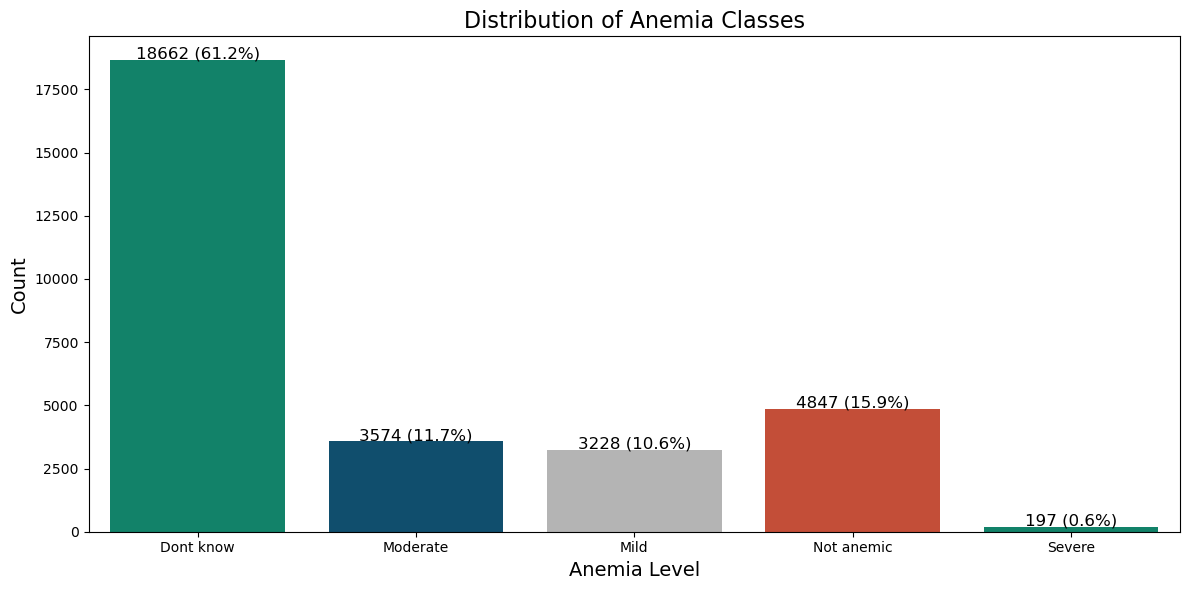


=== 5-Fold Cross-Validation Scores ===
Logistic Regression:
  CV Accuracy: 0.9281 ± 0.0025
  Train Accuracy: 0.7717
  Test Accuracy: 0.7794
  Difference (Train-Test): -0.0077
Logistic Regression:
  CV Accuracy: 0.9281 ± 0.0025
  Train Accuracy: 0.7717
  Test Accuracy: 0.7794
  Difference (Train-Test): -0.0077
Decision Tree:
  CV Accuracy: 0.9622 ± 0.0024
  Train Accuracy: 1.0000
  Test Accuracy: 0.9653
  Difference (Train-Test): 0.0347
Decision Tree:
  CV Accuracy: 0.9622 ± 0.0024
  Train Accuracy: 1.0000
  Test Accuracy: 0.9653
  Difference (Train-Test): 0.0347
Random Forest:
  CV Accuracy: 0.9670 ± 0.0025
  Train Accuracy: 1.0000
  Test Accuracy: 0.9636
  Difference (Train-Test): 0.0363
Random Forest:
  CV Accuracy: 0.9670 ± 0.0025
  Train Accuracy: 1.0000
  Test Accuracy: 0.9636
  Difference (Train-Test): 0.0363
Extra Trees:
  CV Accuracy: 0.9127 ± 0.0048
  Train Accuracy: 1.0000
  Test Accuracy: 0.9108
  Difference (Train-Test): 0.0891
Extra Trees:
  CV Accuracy: 0.9127 ± 0.0048
 

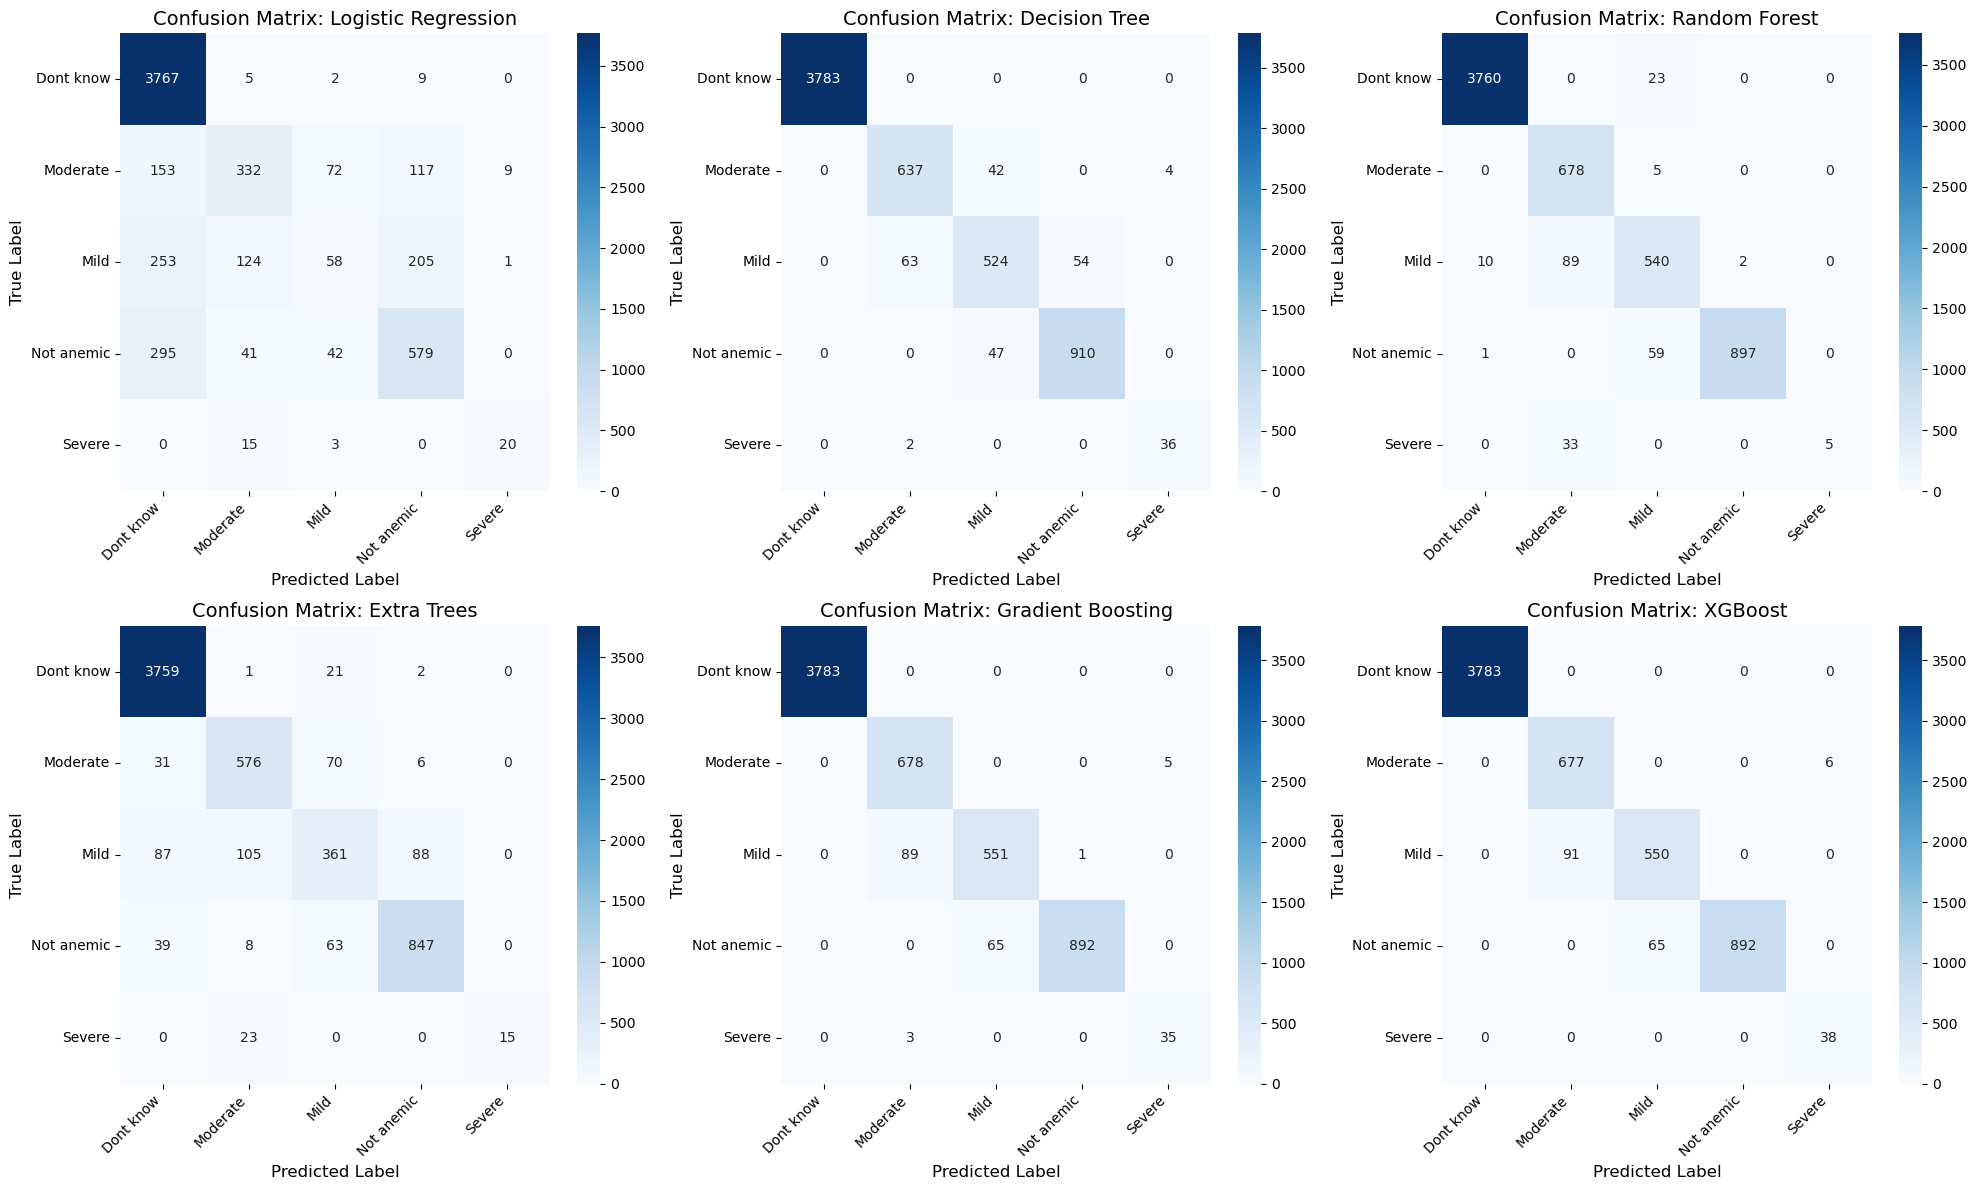

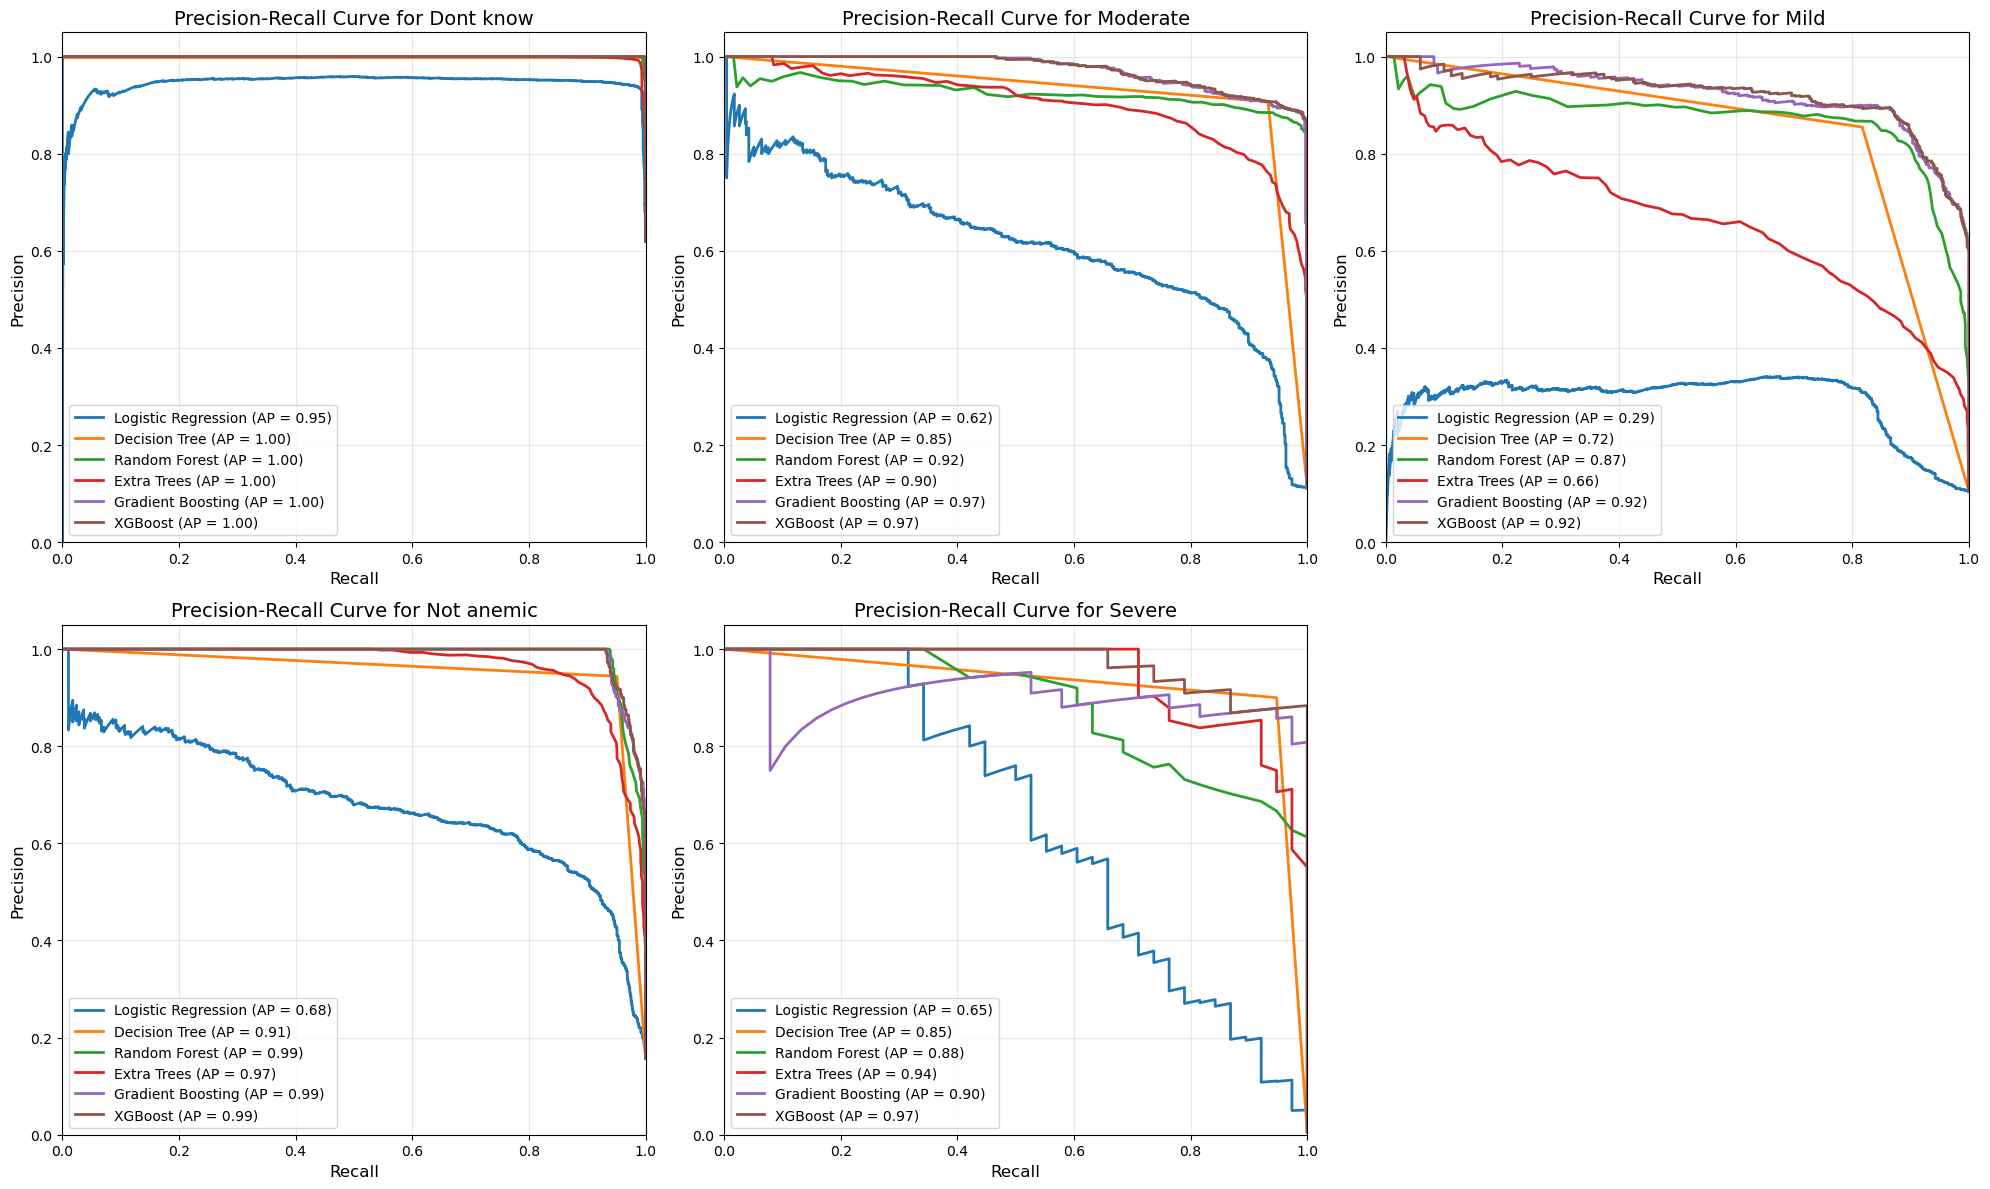


=== Train vs Test AUC for detecting overfitting ===
Logistic Regression:
  Average Train AUC: 0.9153
  Average Test AUC: 0.9206
  Difference (Train-Test): -0.0053
  Class 'Dont know': Train AUC=0.9506, Test AUC=0.9563, Diff=-0.0057
  Class 'Moderate': Train AUC=0.9063, Test AUC=0.9152, Diff=-0.0089
  Class 'Mild': Train AUC=0.8128, Test AUC=0.8147, Diff=-0.0019
  Class 'Not anemic': Train AUC=0.9140, Test AUC=0.9261, Diff=-0.0121
  Class 'Severe': Train AUC=0.9926, Test AUC=0.9906, Diff=0.0020

Logistic Regression:
  Average Train AUC: 0.9153
  Average Test AUC: 0.9206
  Difference (Train-Test): -0.0053
  Class 'Dont know': Train AUC=0.9506, Test AUC=0.9563, Diff=-0.0057
  Class 'Moderate': Train AUC=0.9063, Test AUC=0.9152, Diff=-0.0089
  Class 'Mild': Train AUC=0.8128, Test AUC=0.8147, Diff=-0.0019
  Class 'Not anemic': Train AUC=0.9140, Test AUC=0.9261, Diff=-0.0121
  Class 'Severe': Train AUC=0.9926, Test AUC=0.9906, Diff=0.0020

Decision Tree:
  Average Train AUC: 1.0000
  Averag

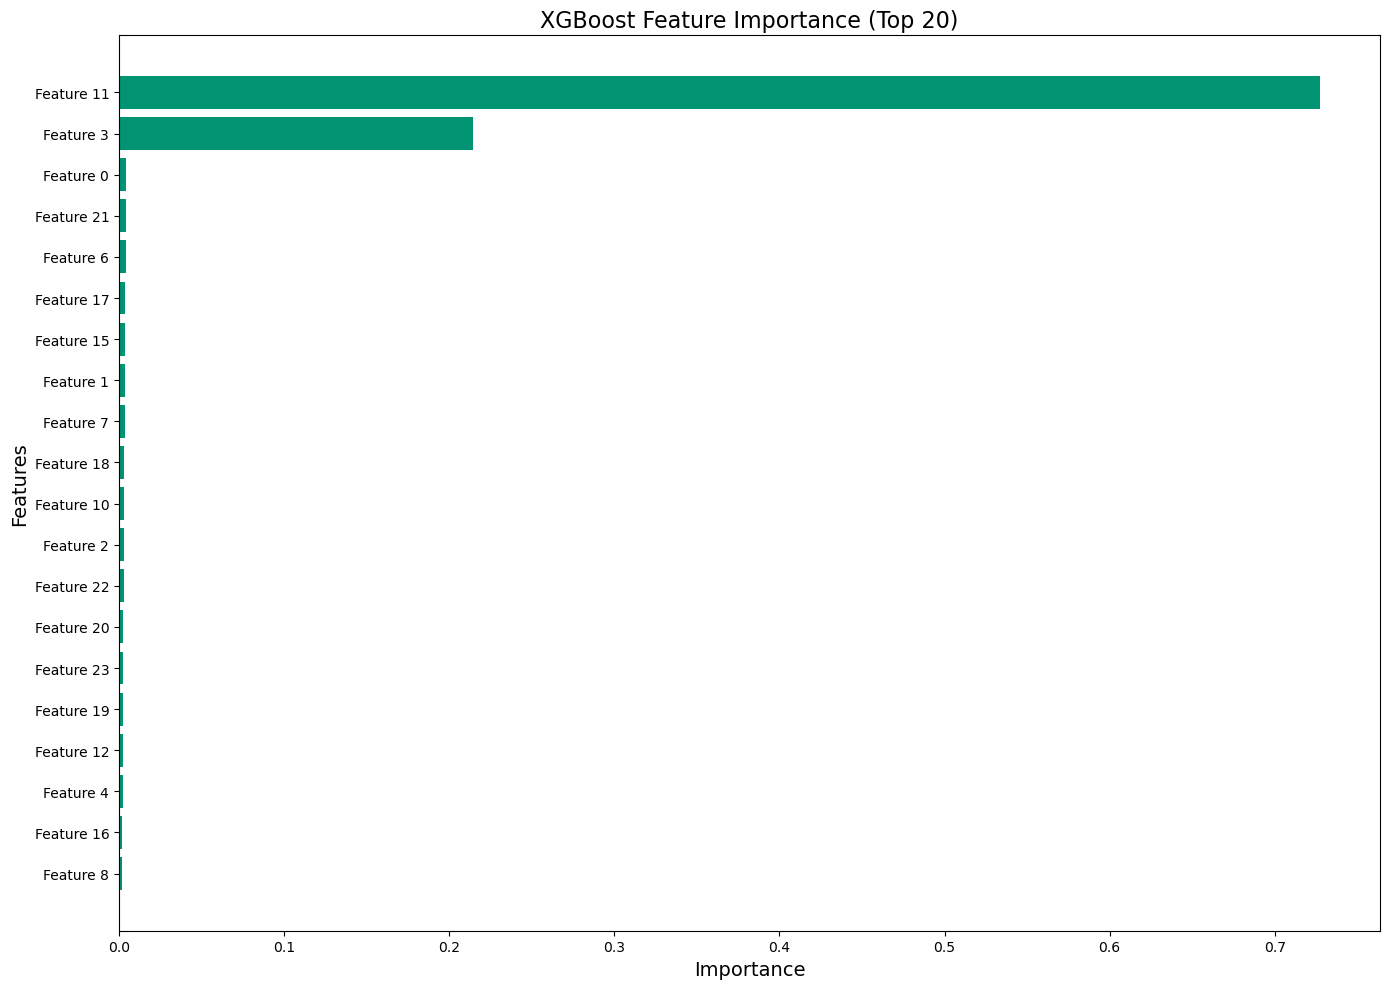

In [55]:
# Comprehensive Model Evaluation
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

# 1. Check class distribution to identify any imbalance
class_counts = pd.Series(y).value_counts().sort_index()
class_names = {0: 'Dont know', 1: 'Moderate', 2: 'Mild', 3: 'Not anemic', 4: 'Severe'}

print("Target class distribution:")
for cls, count in class_counts.items():
    print(f"{class_names[cls]}: {count} ({count/len(y):.2%})")

# Create a bar plot of class distribution
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=class_counts.index.map(class_names), y=class_counts.values, palette=pal)
plt.title('Distribution of Anemia Classes', fontsize=16)
plt.xlabel('Anemia Level', fontsize=14)
plt.ylabel('Count', fontsize=14)
for i, v in enumerate(class_counts.values):
    ax.text(i, v + 50, f"{v} ({v/len(y):.1%})", ha='center', fontsize=12)
plt.tight_layout()
plt.show()

# Dictionary to store all models for evaluation
models = {
    'Logistic Regression': lrg,
    'Decision Tree': dtc,
    'Random Forest': rd,
    'Extra Trees': ex,
    'Gradient Boosting': gb,
    'XGBoost': xgb_model
}

# 2. Cross-validation for all models
print("\n=== 5-Fold Cross-Validation Scores ===")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print(f"{name}:")
    print(f"  CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"  Train Accuracy: {train_score:.4f}")
    print(f"  Test Accuracy: {test_score:.4f}")
    print(f"  Difference (Train-Test): {train_score - test_score:.4f}")

# 3. Plot confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix: {name}', fontsize=14)
    axes[i].set_xlabel('Predicted Label', fontsize=12)
    axes[i].set_ylabel('True Label', fontsize=12)
    # Set tick labels
    axes[i].set_xticklabels([class_names[j] for j in range(5)], rotation=45, ha='right')
    axes[i].set_yticklabels([class_names[j] for j in range(5)], rotation=0)

plt.tight_layout()
plt.show()

# 4. Plot Precision-Recall curves (especially useful for imbalanced datasets)
n_classes = len(np.unique(y_test))

# Create a figure with 5 subplots (one for each class)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for c in range(n_classes):
    ax = axes[c]
    class_name = class_names[c]
    
    # Plot PR curve for each model for this class
    for name, model in models.items():
        y_proba = model.predict_proba(X_test)
        
        # Binarize the labels for this class
        y_true_bin = np.zeros_like(y_test, dtype=int)
        y_true_bin[y_test == c] = 1
        
        precision, recall, _ = precision_recall_curve(y_true_bin, y_proba[:, c])
        ap = average_precision_score(y_true_bin, y_proba[:, c])
        
        ax.plot(recall, precision, lw=2, label=f'{name} (AP = {ap:.2f})')
    
    ax.set_title(f'Precision-Recall Curve for {class_name}', fontsize=14)
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc='lower left', fontsize=10)
    ax.grid(True, alpha=0.3)

if n_classes < 6:  # Hide the unused subplot if we have fewer than 6 classes
    axes[5].axis('off')

plt.tight_layout()
plt.show()

# 5. Separate train vs test AUC to detect overfitting
print("\n=== Train vs Test AUC for detecting overfitting ===")
for name, model in models.items():
    # Calculate AUC on train set
    train_auc = []
    test_auc = []
    
    for c in range(n_classes):
        # Get probabilities
        y_train_prob = model.predict_proba(X_train)[:, c]
        y_test_prob = model.predict_proba(X_test)[:, c]
        
        # Prepare binary labels
        y_train_bin = np.zeros_like(y_train, dtype=int)
        y_train_bin[y_train == c] = 1
        
        y_test_bin = np.zeros_like(y_test, dtype=int)
        y_test_bin[y_test == c] = 1
        
        # Calculate AUC
        train_auc.append(roc_auc_score(y_train_bin, y_train_prob))
        test_auc.append(roc_auc_score(y_test_bin, y_test_prob))
    
    print(f"{name}:")
    print(f"  Average Train AUC: {np.mean(train_auc):.4f}")
    print(f"  Average Test AUC: {np.mean(test_auc):.4f}")
    print(f"  Difference (Train-Test): {np.mean(train_auc) - np.mean(test_auc):.4f}")
    
    for c in range(n_classes):
        print(f"  Class '{class_names[c]}': Train AUC={train_auc[c]:.4f}, Test AUC={test_auc[c]:.4f}, Diff={train_auc[c]-test_auc[c]:.4f}")
    print()

# 6. Feature importance visualization for interpretability
if hasattr(xgb_model, 'feature_importances_'):
    plt.figure(figsize=(14, 10))
    # Get feature names
    feature_names = X.columns if hasattr(X, 'columns') else [f"Feature {i}" for i in range(X.shape[1])]
    
    # Get and sort feature importances
    importances = xgb_model.feature_importances_
    indices = np.argsort(importances)[-20:]  # Top 20 features
    
    # Plot the feature importances
    plt.barh(range(len(indices)), importances[indices], color=pal[0])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.title('XGBoost Feature Importance (Top 20)', fontsize=16)
    plt.tight_layout()
    plt.show()

# Kết luận và Phân tích Cuối cùng

## Tổng quan về Hiệu suất Mô hình

Qua việc phân tích toàn diện các mô hình dự đoán thiếu máu, ta có thể rút ra một số kết luận quan trọng:

### 1. So sánh các Mô hình
- Các mô hình dựa trên cây quyết định (XGBoost, GradientBoosting, RandomForest, ExtraTrees) đều thể hiện hiệu suất rất cao với AUC gần 1.00 cho hầu hết các lớp
- Logistic Regression có hiệu suất thấp hơn, đặc biệt là với lớp Mild (thiếu máu nhẹ), cho thấy đây là lớp khó phân loại nhất
- Sự chênh lệch giữa AUC trên tập train và test cho thấy hiện tượng overfitting ở các mô hình phức tạp (tree-based models)

### 2. Phân tích Mất cân bằng Dữ liệu
- Phân bố các lớp trong dữ liệu không đồng đều, với đa số là "Not anemic" và "Dont know"
- Lớp "Severe" (thiếu máu nặng) có số lượng mẫu ít nhất, nhưng vẫn được dự đoán với độ chính xác tương đối cao
- Precision-Recall curves cho thấy các mô hình duy trì hiệu suất tốt ngay cả với các lớp thiểu số

### 3. Các Yếu tố Quan trọng trong Dự đoán Thiếu máu
- Hemoglobin level (hemoglobin_altitude và hemoglobin_altitude_smoking) là các yếu tố quan trọng nhất trong dự đoán tình trạng thiếu máu
- Tuổi (age) có ảnh hưởng đáng kể đến nguy cơ thiếu máu, với nhóm tuổi từ 27-37 có nguy cơ cao hơn
- Các yếu tố liên quan đến kinh tế xã hội (wealth_index) và điều kiện sống (residence) cũng có ảnh hưởng đến tỷ lệ thiếu máu

### 4. Mối liên hệ giữa Hút thuốc và Thiếu máu
- Phân tích cho thấy có sự liên hệ giữa việc hút thuốc và nồng độ hemoglobin
- Người hút thuốc thường có hemoglobin levels khác biệt so với người không hút thuốc, tuy nhiên cần nghiên cứu thêm để xác định rõ mối tương quan

## Ý nghĩa Thực tiễn

1. **Ứng dụng lâm sàng**: Các mô hình này có thể hỗ trợ các chuyên gia y tế trong việc sàng lọc ban đầu cho bệnh nhân có nguy cơ thiếu máu

2. **Can thiệp y tế công cộng**: Việc xác định các nhóm có nguy cơ cao (dựa trên tuổi, điều kiện sống) có thể giúp định hướng các chương trình y tế công cộng

3. **Cá nhân hóa chẩn đoán**: Phương pháp dự đoán này có thể được tích hợp vào các hệ thống hỗ trợ quyết định lâm sàng để cải thiện độ chính xác chẩn đoán

## Hướng Phát triển Tương lai

1. **Tối ưu hóa mô hình**: Áp dụng các kỹ thuật regularization để giảm overfitting ở các mô hình phức tạp

2. **Cân bằng dữ liệu**: Sử dụng kỹ thuật như SMOTE hoặc class weights để cải thiện hiệu suất với các lớp thiểu số

3. **Tích hợp dữ liệu bổ sung**: Thu thập thêm các biến số liên quan đến chế độ ăn, tiền sử bệnh lý và các yếu tố nguy cơ khác

4. **Phát triển mô hình nhẹ**: Tạo các phiên bản nhẹ hơn của mô hình để có thể triển khai trong môi trường hạn chế về tài nguyên

5. **Nghiên cứu theo chiều dọc**: Theo dõi các đối tượng theo thời gian để đánh giá hiệu quả của các can thiệp dựa trên dự đoán của mô hình

Dự án này đã chứng minh tiềm năng của học máy trong việc hỗ trợ đánh giá và dự đoán tình trạng thiếu máu, một vấn đề sức khỏe công cộng quan trọng toàn cầu. Với việc tiếp tục cải tiến mô hình và mở rộng dữ liệu, các công cụ dự đoán này có thể trở thành một phần quan trọng trong chiến lược phòng ngừa và quản lý thiếu máu.